In [1]:
import numpy as np
import pandas as pd
import os
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
import shap
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import precision_score, recall_score, f1_score
from copy import deepcopy
from math import sqrt

In [2]:
merged_cohort = pd.read_csv("merged_file.csv")

In [3]:
merged_cohort.head()

,Outcome_Occlusion_MI,Age,HR,PR,QRSd,mfpQRSaxis,fpTaxis,txzQRSaxis,QRSTangle,mQRSTangle,...,tamp_III,tamp_aVR,tamp_aVL,tamp_aVF,tamp_V1,tamp_V2,tamp_V3,tamp_V4,tamp_V5,tamp_V6
0,0,78.0,116.0,94.0,107.0,7.0,107.0,79.0,163.0,142.0,...,46.0,0.0,-61.0,63.0,132.0,201.0,319.0,125.0,59.0,-65.0
1,0,84.0,71.0,174.0,136.0,53.0,NaN,51.0,137.0,113.0,...,69.0,51.0,32.0,-72.0,344.0,742.0,668.0,172.0,-153.0,23.0
2,0,76.0,73.0,191.0,110.0,-72.0,56.0,110.0,153.0,147.0,...,50.0,-131.0,29.0,103.0,-50.0,81.0,186.0,155.0,101.0,60.0
3,0,53.0,76.0,134.0,97.0,71.0,58.0,117.0,50.0,78.0,...,195.0,-249.0,-38.0,266.0,-101.0,89.0,450.0,545.0,656.0,272.0
4,0,34.0,76.0,160.0,87.0,43.0,70.0,26.0,45.0,38.0,...,169.0,-150.0,-59.0,199.0,75.0,192.0,128.0,103.0,127.0,150.0


In [4]:
y = merged_cohort['Outcome_Occlusion_MI']
X = merged_cohort.drop('Outcome_Occlusion_MI', axis=1)
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, 
    test_size=0.3,  # 30% for val+test (which is 15%+15%)
    stratify=y,
    random_state=99
)

# Step 2: Split the temp set into validation and test sets
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp,
    test_size=0.5,  # 50% of 30% = 15% of original data
    stratify=y_temp,  # Maintain stratification in this split too
    random_state=99
)

# Verify the proportions
print(f"Training set: {len(X_train)} samples ({len(X_train)/len(X):.1%})")
print(f"Validation set: {len(X_val)} samples ({len(X_val)/len(X):.1%})")
print(f"Test set: {len(X_test)} samples ({len(X_test)/len(X):.1%})")

Training set: 5119 samples (70.0%)
Validation set: 1097 samples (15.0%)
Test set: 1097 samples (15.0%)


In [5]:
for el in X_train.columns:
    X_train[el].fillna(X_train[el].mode()[0], inplace=True)
    X_test[el].fillna(X_train[el].mode()[0], inplace=True)
    X_val[el].fillna(X_train[el].mode()[0], inplace=True)

y_train = np.ravel(np.array(y_train.values))
y_test = np.ravel(np.array(y_test.values))
y_val = np.ravel(np.array(y_val.values))

columns = X_train.columns

X_train = np.array(X_train.values)
X_test = np.array(X_test.values)
X_val = np.array(X_val.values)

scaler = preprocessing.StandardScaler().fit(X_train) # Compute mean and std of training set
X_train = scaler.transform(X_train, copy=True)
X_test = scaler.transform(X_test, copy=True) # Standardize X_test using training mean and std
X_val = scaler.transform(X_val, copy=True)

C:\Users\arthu\AppData\Local\Temp\ipykernel_52792\4220382636.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  X_train[el].fillna(X_train[el].mode()[0], inplace=True)
C:\Users\arthu\AppData\Local\Temp\ipykernel_52792\4220382636.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.



In [12]:
def train_clf_RF(n_estimators=20):
    clf = RandomForestClassifier(class_weight='balanced_subsample', criterion='entropy', n_jobs=-1, random_state=42,
                            max_features='log2', 
                            n_estimators=n_estimators,
                            min_samples_split=0.01,
                            min_samples_leaf=0.0001,
                            min_impurity_decrease=1e-2,
                            bootstrap=True,
                            ccp_alpha=1e-2,
                            max_samples=0.75,
                            oob_score=True)
    clf = CalibratedClassifierCV(clf, cv=5, method="isotonic")
    return clf

In [7]:
def plot_ROC_curve(fpr, tpr, roc_auc, title):
    plt.figure(figsize=[5, 5])
    plt.title(title)
    plt.plot(fpr, tpr, color='b',
                 label=r'RF (AUC = %0.3f)' % (roc_auc),
                 lw=2, alpha=.8)
    plt.plot([0, 1], [0, 1], linestyle='--', lw=1, color='grey', alpha=.5)
    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate = 1 - Specificity')
    plt.ylabel('True Positive Rate = Sensitivity')
    plt.legend(loc="lower right")
    plt.show()

In [8]:
def results(pred_probas):
    OMI_score = np.round(pred_probas[:, 1]*100, decimals=2)
    y_pred = np.where(OMI_score<5, 'Low risk', 'Intermediate risk')
    y_pred = np.where(OMI_score>=20, 'High risk', y_pred)
    
    results = {
        'Low risk': [np.count_nonzero(y_pred == 'Low risk')],
        'Intermediate risk': [np.count_nonzero(y_pred == 'Intermediate risk')],
        'High risk': [np.count_nonzero(y_pred == 'High risk')]
    }
    return(pd.DataFrame(data=results, index=['Count (N)']))

Train


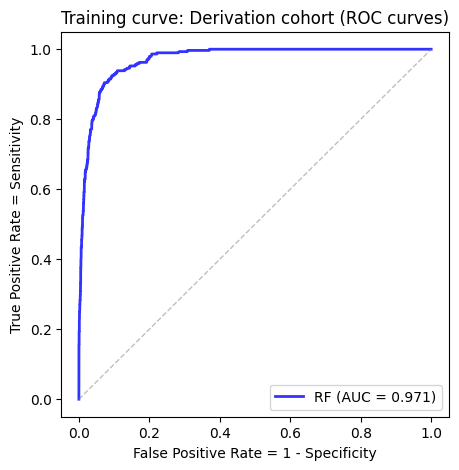

recall_clinical_score is:  0.726962457337884
f1 score is:  0.6645865834633385


In [9]:
print("Train")
    
clf.fit(X_train, y_train)
pred_probas_train = clf.predict_proba(X_train)
risk_groups_train = results(pred_probas_train)

# Compute ROC curve and area under the curve
fpr, tpr, thresholds = roc_curve(y_train, pred_probas_train[:,1])
roc_auc = auc(fpr, tpr)
plot_ROC_curve(fpr, tpr, roc_auc, 'Training curve: Derivation cohort (ROC curves)')

y_pred_clinical = (pred_probas_train[:,1] >= 0.20).astype(int)
recall_clinical = recall_score(y_train, y_pred_clinical)
f1 = f1_score(y_train, y_pred_clinical)
print("recall_clinical_score is: ", recall_clinical)
print("f1 score is: ", f1)

In [10]:
print("Train")
start_estimator = 10
max_estimator = 500
recall_train = []
recall_val = []

# Create progress bar for long running process
from tqdm import tqdm

for i in tqdm(range(start_estimator, max_estimator)):
    clf = train_clf_RF(i)
    clf.fit(X_train, y_train)
    pred_probas_train = clf.predict_proba(X_train)
    risk_groups_train = results(pred_probas_train)
    
    # Compute ROC curve and area under the curve
    fpr, tpr, thresholds = roc_curve(y_train, pred_probas_train[:,1])
    roc_auc = auc(fpr, tpr)
    #roc_auc_list_train.append(roc_auc)
    y_pred_clinical = (pred_probas_train[:,1] >= 0.20).astype(int)
    recall_clinical = recall_score(y_train, y_pred_clinical)
    recall_train.append(recall_clinical)
    
    #print("current rauc is: ", roc_auc)
    #compute test portion
    pred_probas_val = clf.predict_proba(X_val)
    risk_groups_val = results(pred_probas_val)
    fpr, tpr, thresholds = roc_curve(y_val, pred_probas_val[:,1])
    roc_auc = auc(fpr, tpr)
    y_val_clinical = (pred_probas_val[:,1] >= 0.20).astype(int)
    recall_clinical_val = recall_score(y_val, y_val_clinical)
    recall_val.append(recall_clinical_val)

Train


C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\ensemble\_forest.py:612: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.            | 0/490 [00:00<?, ?it/s]
  warn(
C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\ensemble\_forest.py:612: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\ensemble\_forest.py:612: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\ensemble\_forest.py:612: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
C:\Users\arthu\PycharmPr

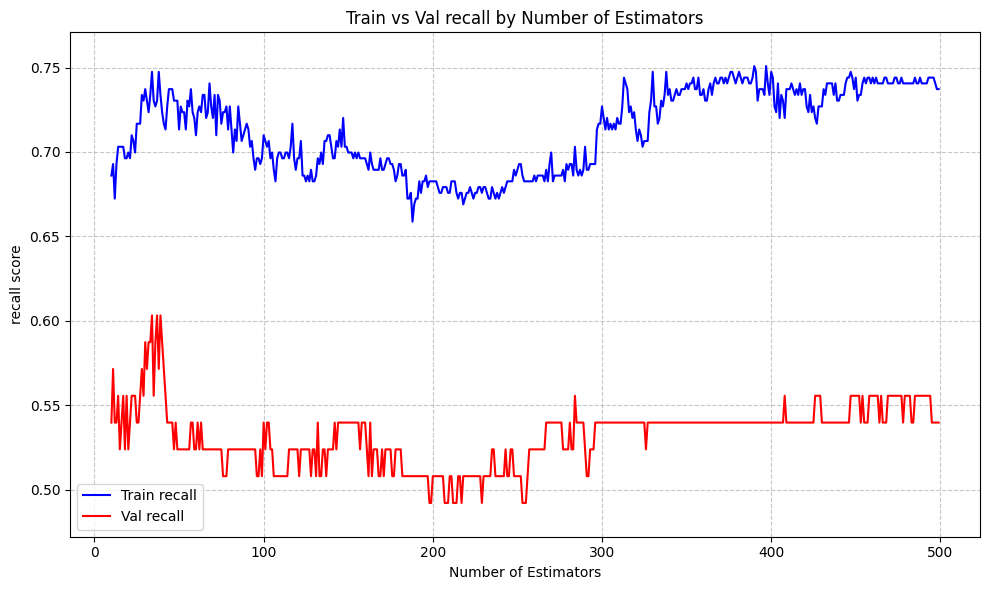


Best Test recall: 0.6032 (n_estimators = 34)


In [11]:
import matplotlib.pyplot as plt

# Create array of estimator values for x-axis
estimator_range = range(start_estimator, max_estimator)

# Create the plot
plt.figure(figsize=(10, 6))
plt.plot(estimator_range, recall_train, label='Train recall', color='blue')
plt.plot(estimator_range, recall_val, label='Val recall', color='red')

# Customize the plot
plt.xlabel('Number of Estimators')
plt.ylabel('recall score')
plt.title('Train vs Val recall by Number of Estimators')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)

# Optional: Set y-axis limits slightly above and below the data range
plt.ylim(min(min(recall_train), min(recall_val)) - 0.02,
         max(max(recall_train), max(recall_val)) + 0.02)

# Show the plot
plt.tight_layout()
plt.show()

# Print the best test AUC and corresponding number of estimators
best_val_recall = max(recall_val)
best_n_estimators = recall_val.index(best_val_recall) + start_estimator
print(f"\nBest Test recall: {best_val_recall:.4f} (n_estimators = {best_n_estimators})")

In [13]:
clf = train_clf_RF(34)

In [14]:
risk_groups_train.head()

,Low risk,Intermediate risk,High risk
Count (N),4039,730,350


In [15]:
print('Val')
pred_probas_val = clf.predict_proba(X_val)
risk_groups_val = results(pred_probas_val)

# Compute ROC curve and area under the curve
fpr, tpr, thresholds = roc_curve(y_val, pred_probas_val[:,1])
roc_auc = auc(fpr, tpr)
plot_ROC_curve(fpr, tpr, roc_auc, 'Validation curve: Derivation cohort (ROC curves)')

#plot_Shapley(clf, X_test, columns, 'Derivation cohort', 25)
y_val_clinical = (pred_probas_val[:,1] >= 0.20).astype(int)
recall_clinical_val = recall_score(y_val, y_val_clinical)
f1_val = f1_score(y_val, y_val_clinical)
print("recall_clinical_score is: ", recall_clinical_val)
print("f1 score is: ", f1_val)

Val


NotFittedError: This CalibratedClassifierCV instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.

In [79]:
risk_groups_test.head()

,Low risk,Intermediate risk,High risk
Count (N),838,190,69


Test


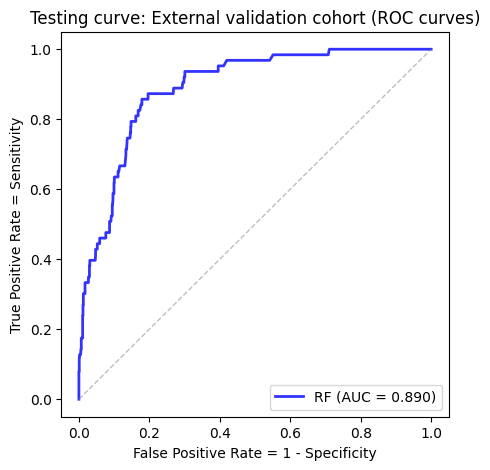

recall_clinical_score is:  0.3968253968253968
f1 score is:  0.373134328358209


In [80]:
print("Test")
pred_probas_test = clf.predict_proba(X_test)
risk_groups_test = results(pred_probas_test)

# Compute ROC curve and area under the curve
fpr, tpr, thresholds = roc_curve(y_test, pred_probas_test[:,1])
roc_auc = auc(fpr, tpr)
plot_ROC_curve(fpr, tpr, roc_auc, 'Testing curve: External validation cohort (ROC curves)')
#plot_Shapley(clf, X_test, columns, 'Derivation cohort', 25)
y_test_clinical = (pred_probas_test[:,1] >= 0.20).astype(int)
recall_clinical_test = recall_score(y_test, y_test_clinical)
f1_test = f1_score(y_test, y_test_clinical)
print("recall_clinical_score is: ", recall_clinical_test)
print("f1 score is: ", f1_test)

In [15]:
risk_groups_val.head()

,Low risk,Intermediate risk,High risk
Count (N),2318,747,222
